*David Schlangen, 2019-03-24*

# Task: Resolving wh-Questions

We have discussed the task of resolving (answering) polar questions in the denotations notebook. The task of answering *wh*-questions goes beyond that, and will be discussed here.

In [1]:
# imports

from __future__ import division
import codecs
import json
from itertools import chain, izip, permutations, combinations
from collections import Counter, defaultdict
import ConfigParser
import os
import random
from textwrap import fill
import scipy
import sys
from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Latex, display

pd.set_option('max_colwidth', 250)

In [2]:
# Load up config file (needs path; adapt env var if necessary); local imports

# load config file, set up paths, make project-specific imports
config_path = os.environ.get('VISCONF')
if not config_path:
    # try default location, if not in environment
    default_path_to_config = '../Config/default.cfg'
    if os.path.isfile(default_path_to_config):
        config_path = default_path_to_config

assert config_path is not None, 'You need to specify the path to the config file via environment variable VISCONF.'        

config = ConfigParser.SafeConfigParser()
with codecs.open(config_path, 'r', encoding='utf-8') as f:
    config.readfp(f)

corpora_base = config.get('DEFAULT', 'corpora_base')
preproc_path = config.get('DSGV-PATHS', 'preproc_path')
dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')


sys.path.append(dsgv_home + '/Utils')
from utils import icorpus_code, plot_labelled_bb, get_image_filename, query_by_id
from utils import plot_img_cropped, plot_img_ax, invert_dict, get_a_by_b
sys.path.append(dsgv_home + '/WACs/WAC_Utils')
from wac_utils import create_word2den, is_relational
sys.path.append(dsgv_home + '/Preproc')
from sim_preproc import load_imsim, n_most_sim

sys.path.append('../Common')
from data_utils import load_dfs, plot_rel_by_relid, get_obj_bb, compute_distance_objs
from data_utils import get_obj_key, compute_relpos_relargs_row, get_all_predicate
from data_utils import compute_distance_relargs_row, get_rel_type, get_rel_instances
from data_utils import compute_obj_sizes_row

In [3]:
# Load up preprocessed DataFrames. Slow!
# These DataFrames are the result of pre-processing the original corpus data,
# as per dsg-vision/Preprocessing/preproc.py

df_names = ['vgobjdf', 'vgvqadf', 'vqa']
df = load_dfs(preproc_path, df_names)

## Visual question answering

An image-related task that has become popular recently (beginning with \cite{VQA2015}) is that of answering *wh*-questions about an image. Visual genome also comes with such questions (and their answers; roughly 1,4 million altogether).

Here are some examples:

In [4]:
# some example Q & A's from visual genome
for q,a in df['vgvqadf'].sample(5)[['q', 'a']].values:
    print "{:>40} {:<40}".format(q, a)

           What is the name on the safe? Butler Street Foundry.                  
                 What are the signs for? To show prices.                         
                 What is the bowl color? Blue and white.                         
                     Where is the spire? In distance.                            
              When is the picture taken? Daytime.                                


There are different ways to set this task up. If it is set up as a choice task between answer possibilities, then it reduces to a sequence of polar questions and hence semantically adds not much to what we discussed in the previous section. (The only new element then is that a decision must be made as to the final selection of the (set of) true answer(s).)

If the task is set up as an open answer task, on the other hand, it goes beyond the whole framework that we have been working with so far, taking on aspects of the natural language *generation* task (to be discussed below). To give an example, to answer a question of the type "what colour is X?", a answer candidate of an appropriate type must first be selected / generated (here, a colour word), and then be evaluated on the denotation of the phrase X. Hence, this task combines interpretation (identification of the object about which the question asks something) and (type-constrained) generation, where the latter requires word/word relations as will be discussed below in the section on *implicature* relations.

The following gives a brief overview of the most frequent types of questions in visual genome (see also the much detailed overview in the original paper, \cite{krishnavisualgenome}):

In [5]:
# Question types in the VQA portion of visual genome
maxrows = 50000
tmp_df = df['vgvqadf'][:maxrows]['q'].str.split(expand=True).iloc[:,:2]
c = Counter((tmp_df.iloc[:,0] + ' ' + tmp_df.iloc[:,1]).tolist())
c.most_common(20)

[(u'What is', 12922),
 (u'What color', 10280),
 (u'Where is', 5328),
 (u'How many', 4688),
 (u'Where are', 2160),
 (u'Where was', 1685),
 (u'Who is', 1653),
 (u'What are', 1385),
 (u'What kind', 951),
 (u'How is', 688),
 (u'Why is', 654),
 (u'What type', 629),
 (u'When was', 456),
 (u'What does', 392),
 (u'Why are', 333),
 (u'What has', 251),
 (u'Who has', 251),
 (u"What's the", 212),
 (u'How are', 207),
 (u'What shape', 193)]

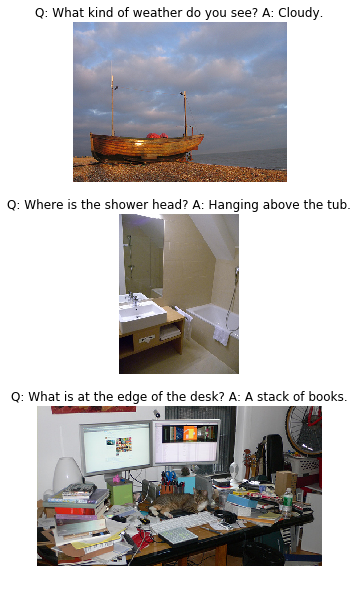

In [6]:
# Some example question / answer pairs
fig, ax = plt.subplots(3,1, figsize=(10, 10))

for n in range(3):
    ic, ii, ques, answ, ri = df['vgvqadf'].sample()['i_corpus image_id q a region_id'.split()].values[0]
    qna = 'Q: {} A: {}'.format(ques, answ)
    plot_img_ax(config, ax[n], 'visual_genome', ii, title=qna)


# N.B.: Plotting the regions that are in the VQA annotation shows that they are
#  quite often very much off...

* **Dataset:** wh-questions
* **Negative Instances:** answers of other questions
* **Source:** visual genome
* **Uses:** learn type-constrained generation of answers

We have also preprocessed the VQAs from the (second version of the) original VQA task, with questions about COCO images. (See <https://visualqa.org/download.html>.)

In [7]:
print "{:,} question / answer pairs".format(len(df['vqa']))

658,111 question / answer pairs


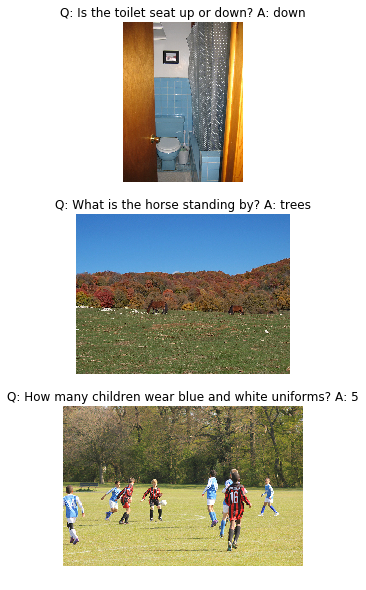

In [8]:
# Some example question / answer pairs
fig, ax = plt.subplots(3,1, figsize=(10, 10))

for n in range(3):
    ic, ii, ques, answ = df['vqa'][df['vqa']['split'] == 'train'].sample()['i_corpus image_id q a'.split()].values[0]
    qna = 'Q: {} A: {}'.format(ques, answ)
    plot_img_ax(config, ax[n], 'mscoco', ii, title=qna)

Note: For this very popular task exist many more datasets, especially ones that are meant to be more challenging in terms of the reasoning that is required to answer them. It would be a nice first project to add these to our format.

## "Multi-Hop" Question Answering

The wh-questions discussed above directly ask about visible properties of objects. An interesting variant, which to our knowledge has not yet been proposed, would be one where the queried properties can only be *inferred* on the basis of additional, non-visual knowledge.

To give an example, for the following picture (from visual genome), a question of that kind could be "What can move around?". A correct answer would need to identify both the person and the car in the image (perhaps ostensively). This connects visual identification with conceptual reasoning, and lends itself to being augmented with an explanation. Here, such an explanation would need to make the additional premises "people can move; this is a person; cars can move; this is a car" explicit.

(More examples of such conceptual questions appropriate for this example image: "What is a living thing?" [Answer: the plants, the human]; "What has been built?" [Answer: the street, the sidewalk, the buildings].)

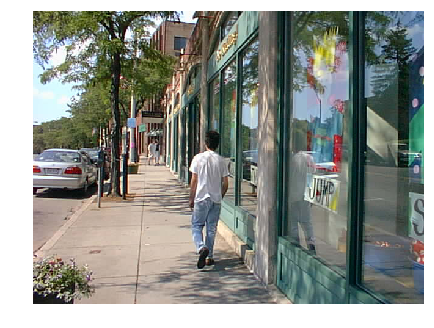

In [9]:
# an example from visual genome
pick_row = 12568
this_row = df['vgobjdf'].iloc[pick_row]
ic, ii = this_row['i_corpus image_id'.split()].values

plot_labelled_bb(get_image_filename(config, ic, ii), [], figsize=(7,7))
#                 query_by_id(df['vgobjdf'], (ic, ii), ['bb', 'obj_id']).values)

What this task adds then is a combination of categorisation of objects in the image and activation of further, conceptual knowledge about these categories (e.g.,  membership in superclasses, typical uses, etc.), bringing this together in the task of forming ad-hoc categories ("things that can move around").

(Data for such a task would need to be collected.)

# References

[<a id="cit-VQA2015" href="#call-VQA2015">1</a>] S. Antol, A. Agrawal, J. Lu <em>et al.</em>, ``_VQA: Visual Question Answering_'', International Conference on Computer Vision (ICCV),  2015.

[<a id="cit-krishnavisualgenome" href="#call-krishnavisualgenome">2</a>] R. Krishna, Y. Zhu, O. Groth <em>et al.</em>, ``_Visual Genome: Connecting Language and Vision Using Crowdsourced Dense Image Annotations_'', ,  2016.  [online](https://arxiv.org/abs/1602.07332)

